In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph
import healpy as hp
from deepsphere import utils
from pyevtk.hl import unstructuredGridToVTK
from pyevtk.vtk import VtkTriangle, VtkQuad
import pyshtools

# HERE WE JUST DEFINE THREE CLASSES FOR THE DIFFERENT SAMPLINGS

In [2]:
class MyGraph(Graph):
    
    def __init__(self, W, coords):
        super(MyGraph, self).__init__(W=W, coords=coords)
        

    
    def _init_vtk(self):
        from pyevtk.vtk import VtkTriangle, VtkQuad
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid


    def save_signal(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})
        
    def save_mesh(self, file="mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)

In [3]:
class NonUniform(MyGraph):
    
    def make_coords(self):
        alpha = np.arange(2 * 16) * np.pi / 16
        l = 1
        alpha1 = np.linspace(0, l, 14, endpoint=False)
        alpha2 = np.linspace(l, np.pi-l, 5, endpoint=False)
        alpha3 = np.linspace(np.pi-l, np.pi, 14, endpoint=False)        
        beta = np.concatenate([alpha1, alpha2, alpha3])
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords[2*16-1:]

        
    def __init__(self):
        self.npix = 1025
        coords = self.make_coords()
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/0.1)
        W = W-np.diag(np.diag(W))
        super(NonUniform, self).__init__(W=W, coords=coords)
        self._init_vtk()     

In [4]:
class FullEquiangular(MyGraph):

    sigmas = {1:1,
              2:0.3,
              4: 0.175, 
              8: 0.0525,
              16: 0.015,
              32: 0.004}
    
    def make_coords(self, bw):
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        coords = coords[2*bw-1:]
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, bw=8):
        self.bw = bw
        self.npix = 2*bw*(2*bw-1)+1
        coords = self.make_coords(bw)
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullEquiangular, self).__init__(W=W, coords=coords)
        self._init_vtk()
    
    def power_spectrum_analysis(self, harmonics=None):
        
        def to_array(f, bw):
            """From a 1-d vector to a 2D grid necessary to initiate a pyshtools.SHGrid object"""
            height, width = 2*bw, 2*bw
            array = np.zeros((height, width))  # shape=(longitude, latitude)
            f = np.append([f[0]]*(2*bw-1), f)  # correct! the first line is the North pole repeated 2bw times
            # now we need to undo the meshgrid
            assert f.size == array.size
            for n, fx in enumerate(f):
                j = n%width
                i = n//width
                array[i, j] = fx
            return array
        
        if harmonics is None:
            bw = self.bw
            lmax = bw-1
            n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
            self.compute_fourier_basis()

            cl = np.empty((n_harmonics, lmax+1))
            for i in range(n_harmonics):
                eigenvector = self.U[:, i]
                eig_array = to_array(eigenvector, bw)
                g = pyshtools.SHGrid.from_array(eig_array)
                clm = g.expand(normalization='unnorm')
                cl[i] = clm.spectrum()

            spectral_content = np.empty((lmax+1, lmax+1))
            start = 0
            for ell in range(lmax+1):
                end = start + (2 * ell + 1)
                spectral_content[ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
                start = end

            fig1, ax = plt.subplots()
            fig2, ax2 = plt.subplots()

            sc = spectral_content
            sc = sc / sc[0, 0]
            im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
            ax.set_title(rf'$bw={bw}$')
            energy_in = np.diag(sc)
            ax2.plot(energy_in, 'o', label=rf'$bw={bw}$')

            ax2.legend();
        
        else:
            bw = self.bw
            lmax = bw-1
            n_harmonics = harmonics.shape[1]
            cl = np.empty((n_harmonics, lmax+1))
            for i in range(n_harmonics):
                eigenvector = harmonics[:, i]
                eig_array = to_array(eigenvector, bw)
                g = pyshtools.SHGrid.from_array(eig_array)
                clm = g.expand(normalization='unnorm')
                cl[i] = clm.spectrum()

            spectral_content = np.empty((lmax+1, lmax+1))
            start = 0
            for ell in range(lmax+1):
                end = start + (2 * ell + 1)
                spectral_content[ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
                start = end

            fig1, ax = plt.subplots()
            fig2, ax2 = plt.subplots()

            sc = spectral_content
            sc = sc / sc[0, 0]
            im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
            ax.set_title(rf'$bw={bw}$')
            energy_in = np.diag(sc)
            ax2.plot(energy_in, 'o', label=rf'$bw={bw}$')

            ax2.legend();
        



In [22]:
class FullHEALPix(MyGraph):
    sigmas = {4:0.5,
              8:0.05,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def make_coords(self):
        indexes = range(self.nside**2 * 12)
        # Get the coordinates.
        x, y, z = hp.pix2vec(self.nside, indexes, nest=True)  # NESTED ordered
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, nside=8, std=None):
        self.nside = nside
        self.npix = 12*nside**2
        coords = self.make_coords()
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        if isinstance(std, float) or isinstance(std, int):
            W = np.exp(-distances_squared / std)
        else:
            W = np.exp(-distances_squared / self.sigmas[nside])
        W = W-np.diag(np.diag(W))
        super(FullHEALPix, self).__init__(W=W, coords=coords)
        self._init_vtk()
    
    def power_spectrum_analysis(self, harmonics=None):
        
        if harmonics is None:
            nside = self.nside
            lmax = 3 * nside - 1

            harmonics = utils.compute_spherical_harmonics(nside, lmax=lmax)
            n_harmonics = harmonics.shape[1]
            cl = np.empty((n_harmonics, lmax+1))
            for i in range(n_harmonics):
                harmonic = hp.reorder(harmonics[:, i], n2r=True)
                cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax, iter=8)

            spectral_content = np.empty((lmax+1, lmax+1))
            start = 0
            for ell in range(lmax+1):
                end = start + (2 * ell + 1)
                spectral_content[ell] = np.sum(cl[start:end,:], axis=0)
                start = end

            fig1, ax = plt.subplots()
            fig2, ax2 = plt.subplots()

            sc = spectral_content
            sc = sc / sc[0, 0]
            im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
            fig1.colorbar(im, ax=ax)
            ax.set_title(rf'$N_{{side}}={nside}$')

            energy_in = np.diag(sc)
            ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

            ax2.legend();
        
        else:
            nside = self.nside
            lmax = 3 * nside - 1
            
            n_harmonics = harmonics.shape[1]
            cl = np.empty((n_harmonics, lmax+1))
            for i in range(n_harmonics):
                harmonic = hp.reorder(harmonics[:, i], n2r=True)
                cl[i] = hp.sphtfunc.anafast(harmonic, lmax=lmax, iter=8)

            spectral_content = np.empty((lmax+1, lmax+1))
            start = 0
            for ell in range(lmax+1):
                end = start + (2 * ell + 1)
                spectral_content[ell] = np.sum(cl[start:end,:], axis=0)
                start = end

            fig1, ax = plt.subplots()
            fig2, ax2 = plt.subplots()

            sc = spectral_content
            sc = sc / sc[0, 0]
            im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
            fig1.colorbar(im, ax=ax)
            ax.set_title(rf'$N_{{side}}={nside}$')

            energy_in = np.diag(sc)
            ax2.plot(energy_in, label=rf'$N_{{side}}={nside}$')

            ax2.legend();




In [23]:
sphere = FullHEALPix()
sphere.save_signal("healpix_weights_low", sphere.W[:,0].toarray().flatten())

# EXAMPLE OF USE OF THE THREE CLASSES ABOVE

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


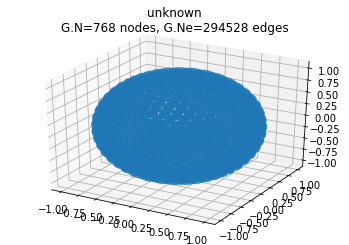

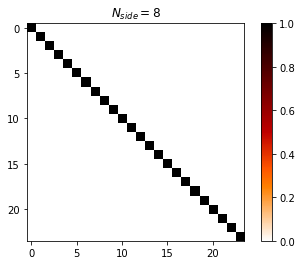

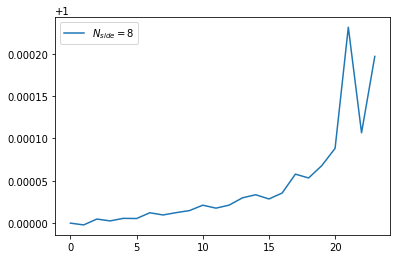

In [6]:
sphere = FullHEALPix(8)
sphere.plot()
sphere.power_spectrum_analysis()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


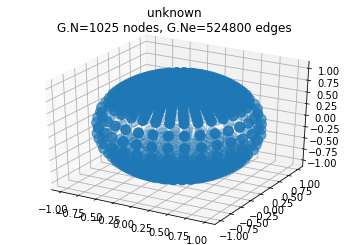

In [7]:
sphere = NonUniform()
sphere.plot()

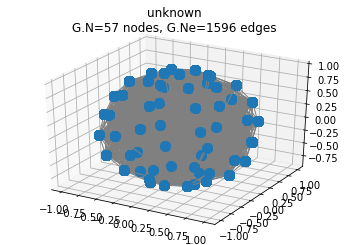

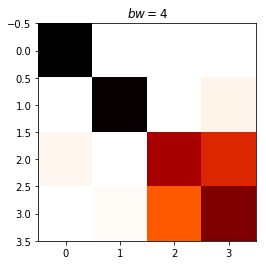

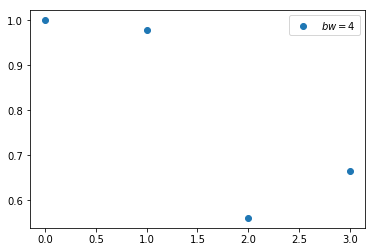

In [8]:
sphere = FullEquiangular(4)
sphere.plot()
sphere.power_spectrum_analysis()

# Finite Element Method (just assembling of the stiffness and mass matrix)

In [15]:
sphere = FullEquiangular(4)

In [16]:
from __future__ import print_function
from scipy.sparse import csr_matrix
from dolfin import *


# Test for PETSc and SLEPc
if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()

if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

spectral_content = dict()

N = 25  # how many eigenvectors do I calculate

# Define mesh, function space
sphere.save_mesh("mesh.xml")
mesh = Mesh("mesh.xml")
global_normal = Expression(("x[0]", "x[1]", "x[2]"), degree=1)
mesh.init_cell_orientations(global_normal)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx
# Assemble stiffness form
A_PETSC = PETScMatrix()
B_PETSC = PETScMatrix()
assemble(a, tensor=A_PETSC)
assemble(b, tensor=B_PETSC)

A_mat = as_backend_type(A_PETSC).mat()
stiffness = csr_matrix(A_mat.getValuesCSR()[::-1], shape=A_mat.size)
B_mat = as_backend_type(B_PETSC).mat()
mass = csr_matrix(B_mat.getValuesCSR()[::-1], shape=B_mat.size)

# REORDERING MASK 
### necessary because the matrices stiffness/mass have been reordered by FEniCS in a way that we don't know: we have to reverse-engineer this ordering by comparing V.tabulate_dof_coordinates() and sphere.coords

In [10]:
def float_almost_equal(a, b):
        tol = 1e-6
        return (a > (b - tol)) and (a < (b + tol))


def almost_equal(matrix, item):
    mask = np.zeros(np.alen(matrix), dtype='bool')
    for i, row in enumerate(matrix):
        sub_array = np.zeros(len(item))
        for j, (x, y) in enumerate(zip(row, item)):
            sub_array[j] = float_almost_equal(x,y)
        if sub_array.all():
            mask[i] = True
    return mask


dofs_x = V.tabulate_dof_coordinates()
coords = mesh.coordinates()
npix = np.alen(coords)
reordering_mask = np.empty(npix, dtype='int')
indexes = np.arange(npix)
for i, item in enumerate(coords):
    reordering_mask[i] = int(indexes[almost_equal(dofs_x, item)][0])
assert len(np.unique(reordering_mask)) == npix

# ------- WHY DO I NEED THIS? I DON'T UNDERSTAND --------
reordering_mask = np.flip(reordering_mask)
# ---------------------------------------------------------

print(reordering_mask)


[ 2  0  4  8  9  3 11 16 14  1  6  7 26 10 22 12 13 15  5 24 25 27 21 28
 19 18 17 23 37 35 34 20 31 30 29 38 36 47 33 32 41 40 39 46 45 44 43 42
 50 49 48 55 54 53 52 51 56]


# FEM and GRAPH FILTERING: DIFFUSION

In [17]:
pos = 20

L = stiffness
B = mass

# here we reorder the matrices produces by FEniCS in order to have the same order of sphere.coords
L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]


B_inv = scipy.sparse.linalg.inv(B)
B_lumped_inverse = np.diag(1./np.sum(B.toarray(), axis=1))

# here we define the signal to be diffused
signal = np.zeros(npix)
signal[pos] = 1

# here we calculate the filters
M = scipy.linalg.expm(-0.08*B_inv@L)
M_lumped = scipy.linalg.expm(-0.08*B_lumped_inverse@L)
HKGL = sphere.L
expL = scipy.linalg.expm(-0.05*HKGL)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [18]:
def diffuse(x):
    return M@x

def diffuse_lumped(x):
    return M_lumped@x

def diffuse_HKGL(x):
    return expL@x

# FEM
signal = np.zeros(npix)
signal[pos] = 1
sphere.save_signal('img/FEM_diffusion0000000', pointData = signal)
for j in range(8):
    # diffusing 3 times
    for i in range(1):
        signal = np.asarray(abs(diffuse(signal)))
    sphere.save_signal('img/FEM_diffusion000000{}'.format(j+1), pointData = signal)

# FEM LUMPED
signal = np.zeros(npix)
signal[pos] = 1
for j in range(8):
    # diffusing 3 times
    for i in range(1):
        signal = np.asarray(abs(diffuse_lumped(signal)))
    sphere.save_signal('img/FEM_lumped_diffusion000000{}'.format(j+1), pointData = signal)

# GRAPH
signal = np.zeros(npix)
signal[pos] = 1
for j in range(8):
    # diffusing 3 times
    for i in range(3):
        signal = diffuse_HKGL(signal)
    sphere.save_signal('img/GRAPH_diffusion000000{}'.format(j+1), pointData = signal)

# SPECTRAL POWER ANALYSIS 
### JUST FOR EQUIANGULAR AND HEALPIX, SINCE FOR THE NONUNIFORM WE DON'T HAVE THE SHT

In [19]:
# Create eigensolver
eigensolver = SLEPcEigenSolver(A_PETSC, B_PETSC)
eigensolver.parameters['spectrum'] = 'target real'
eigensolver.parameters['tolerance'] = 1.e-4
eigensolver.parameters['maximum_iterations'] = 10000

# Compute all eigenvalues of A x = \lambda x
print("Computing eigenvalues. This can take a minute.")
eigensolver.solve(N)

print('Done. Saving results...')

eig_vectors = np.ndarray((npix, N), dtype='float')
eig_values = np.ndarray(N, dtype='float')
for i in range(N):
    # Extract largest (first) eigenpair
    r, c, rx, cx = eigensolver.get_eigenpair(i)

    # Initialize function and assign eigenvector
    u = Function(V)
    u.vector()[:] = rx
    eig_vectors[:, i] = u.compute_vertex_values()
    eig_values[i] = r

Computing eigenvalues. This can take a minute.
Done. Saving results...


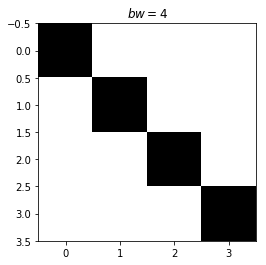

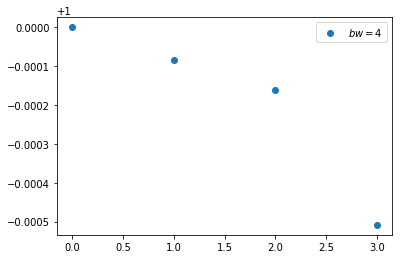

In [20]:
sphere.power_spectrum_analysis(eig_vectors)